#### Linear Regression Modeling: Ames Housing Prices, by Paul H.
Data dictionary. https://ww2.amstat.org/publications/jse/v19n3/decock/datadocumentation.txt

In [105]:
# %matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import GridSearchCV

In [106]:
ames = pd.read_csv('data/ames_housing.csv')
ames.shape

(1460, 81)

(1456, 81)


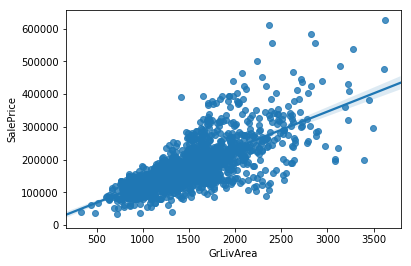

In [107]:
#the link above recommends removing houses with more than 4000 square feet from data set
#(which eliminates unusual observations) 
bools = (ames.GrLivArea <= 4000)
ames = ames[bools]
print(ames.shape)
sns.regplot(ames.GrLivArea, ames.SalePrice)

In [108]:
#ames.head()

In [109]:
ames.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1459
Data columns (total 81 columns):
Id               1456 non-null int64
MSSubClass       1456 non-null int64
MSZoning         1456 non-null object
LotFrontage      1197 non-null float64
LotArea          1456 non-null int64
Street           1456 non-null object
Alley            91 non-null object
LotShape         1456 non-null object
LandContour      1456 non-null object
Utilities        1456 non-null object
LotConfig        1456 non-null object
LandSlope        1456 non-null object
Neighborhood     1456 non-null object
Condition1       1456 non-null object
Condition2       1456 non-null object
BldgType         1456 non-null object
HouseStyle       1456 non-null object
OverallQual      1456 non-null int64
OverallCond      1456 non-null int64
YearBuilt        1456 non-null int64
YearRemodAdd     1456 non-null int64
RoofStyle        1456 non-null object
RoofMatl         1456 non-null object
Exterior1st      1456 non-n

# Regression Considerations

- Collinearity
- Cleaning and Preparing Data
- Test Train Split for Assessment


### Collinearity

The notion of independence of variables is related to the notion of collinearity.  Briefly, we find collinearity anytime we find strong relationships between dependent variables. This can be detected by looking both at plots of the variables themselves against one another, examining the correlation coefficients of variables, and calculating the Variance in Frequency measure for the different features.

Remove any features you believe are highly correlated and refit your model.

In [110]:
ames.corr()['SalePrice']

Id              -0.027455
MSSubClass      -0.088160
LotFrontage      0.356773
LotArea          0.269866
OverallQual      0.800858
OverallCond     -0.080202
YearBuilt        0.535279
YearRemodAdd     0.521428
MasVnrArea       0.478862
BsmtFinSF1       0.395923
BsmtFinSF2      -0.008900
BsmtUnfSF        0.220678
TotalBsmtSF      0.646584
1stFlrSF         0.625235
2ndFlrSF         0.297301
LowQualFinSF    -0.025351
GrLivArea        0.720516
BsmtFullBath     0.235697
BsmtHalfBath    -0.036792
FullBath         0.559048
HalfBath         0.282925
BedroomAbvGr     0.160542
KitchenAbvGr    -0.138849
TotRmsAbvGrd     0.537462
Fireplaces       0.466765
GarageYrBlt      0.499230
GarageCars       0.649256
GarageArea       0.636964
WoodDeckSF       0.322538
OpenPorchSF      0.330361
EnclosedPorch   -0.129774
3SsnPorch        0.047414
ScreenPorch      0.118324
PoolArea         0.032819
MiscVal         -0.021097
MoSold           0.056797
YrSold          -0.023694
SalePrice        1.000000
Name: SalePr

In [111]:
#group "similar" features into lists
age_list = ['YearBuilt','YearRemodAdd']
size_list = ['MasVnrArea','LotArea','LotFrontage','TotalBsmtSF','GrLivArea']
size2_list = ['GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','GrLivArea']
nr_rooms_list = ['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'GarageCars','Fireplaces','TotRmsAbvGrd']
condition_list = ['OverallQual','OverallCond','Functional','KitchenQual','ExterQual','ExterCond']
condition2_list = ['GarageQual','GarageCond','BsmtQual','BsmtCond','BsmtFinType1','BsmtFinType2',
                   'HeatingQC','FireplaceQu','PoolQC','Fence']
dwellingType_list = ['MSSubClass','MSZoning','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1','Exterior2',
                     'MasVnrType','Foundation','GarageType','GarageFinish']
landType_list = ['LotShape','LandContour','LotConfig','LandSlope']
neighborhood_list = ['Neighborhood', 'Street', 'Alley','PavedDrive','Condition1','Condition2']
other_list = ['BsmtExposure','Heating','CentralAir','Electrical']
luxuries_list = ['GarageCars','PoolArea','PoolQC','MiscFeature','Fireplaces','Fence'] #incl a porch/deck metric
sales_list =['MoSold','YrSold','SaleType','SaleCondition']


             MasVnrArea   LotArea  LotFrontage  TotalBsmtSF  GrLivArea
MasVnrArea     1.000000  0.081170     0.162026     0.337869   0.363472
LotArea        0.081170  1.000000     0.387570     0.221940   0.231887
LotFrontage    0.162026  0.387570     1.000000     0.313392   0.341427
TotalBsmtSF    0.337869  0.221940     0.313392     1.000000   0.394829
GrLivArea      0.363472  0.231887     0.341427     0.394829   1.000000


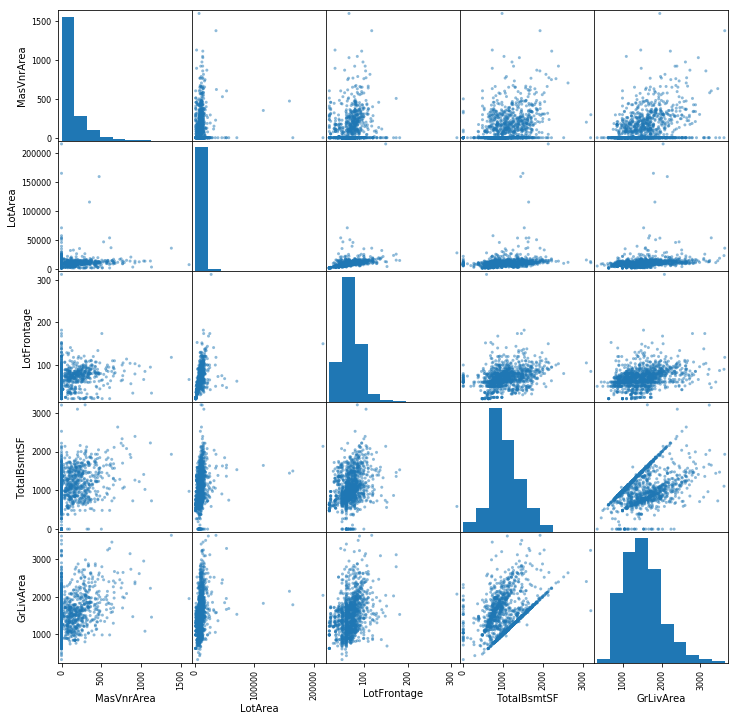

In [112]:
#collinearity
#sns.pairplot(data=ames[size_list]) #fails?
scatter_matrix(ames[size_list], figsize=[12,12]);
print(ames[size_list].corr())

               GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
GarageArea       1.000000    0.219967     0.228089      -0.120615   0.036213   
WoodDeckSF       0.219967    1.000000     0.053498      -0.125151  -0.032472   
OpenPorchSF      0.228089    0.053498     1.000000      -0.092094  -0.005148   
EnclosedPorch   -0.120615   -0.125151    -0.092094       1.000000  -0.037427   
3SsnPorch        0.036213   -0.032472    -0.005148      -0.037427   1.000000   
ScreenPorch      0.053732   -0.073489     0.077261      -0.083154  -0.031526   
PoolArea         0.011637    0.068309     0.030360       0.068796  -0.006770   
GrLivArea        0.454512    0.241827     0.307325       0.016148   0.023967   

               ScreenPorch  PoolArea  GrLivArea  
GarageArea        0.053732  0.011637   0.454512  
WoodDeckSF       -0.073489  0.068309   0.241827  
OpenPorchSF       0.077261  0.030360   0.307325  
EnclosedPorch    -0.083154  0.068796   0.016148  
3SsnPorch        -0.031526 -0

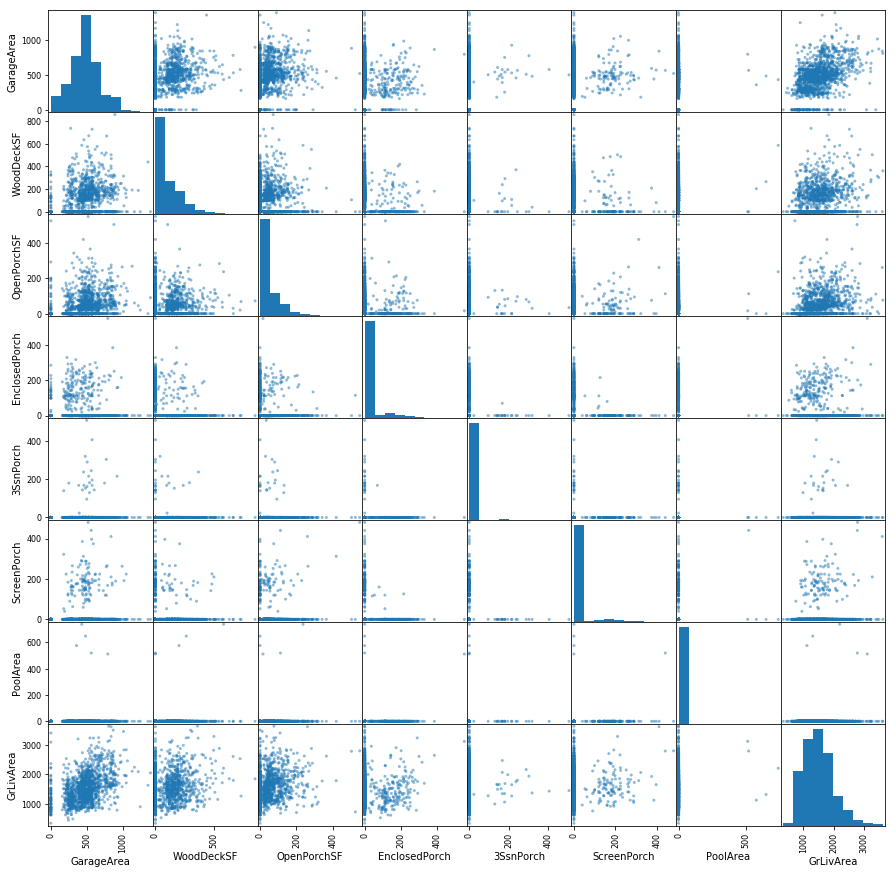

In [113]:
#collinearity
scatter_matrix(ames[size2_list], figsize=[15,15]);
print(ames[size2_list].corr())

In [114]:
#collinearity
#scatter_matrix(ames[nr_rooms_list], figsize=[12,12]);
print(ames[nr_rooms_list].corr())

              BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
BsmtFullBath      1.000000     -0.146201 -0.069457 -0.034861     -0.152268   
BsmtHalfBath     -0.146201      1.000000 -0.061379 -0.015173      0.043331   
FullBath         -0.069457     -0.061379  1.000000  0.130335      0.360990   
HalfBath         -0.034861     -0.015173  0.130335  1.000000      0.224799   
BedroomAbvGr     -0.152268      0.043331  0.360990  0.224799      1.000000   
KitchenAbvGr     -0.041036     -0.037682  0.135352 -0.067694      0.199328   
GarageCars        0.130568     -0.024972  0.465325  0.215800      0.083084   
Fireplaces        0.130933      0.024537  0.236477  0.198394      0.103951   
TotRmsAbvGrd     -0.063715     -0.028715  0.549625  0.338618      0.679346   

              KitchenAbvGr  GarageCars  Fireplaces  TotRmsAbvGrd  
BsmtFullBath     -0.041036    0.130568    0.130933     -0.063715  
BsmtHalfBath     -0.037682   -0.024972    0.024537     -0.028715  
FullBath          

#### Collinearity - conclusions:
GrLivArea is correlated with most other size attributes


TotRmsAbvGrd is correlated with other nrRooms attributes

### Feature Engineering and Cleaning


Consider how to use some of `scikitlearn`'s functionality to deal with missing values.  We want to determine the correct way of dealing with these one by one, and use some of what we know about the data to inform these decisions.  If we have objects that are missing values, we can either exclude the observations, or encode the missing values using some kind of numerical value.  
-Code columns and make sure to replace any `na` values.

In [115]:
ames['Alley'] = ames['Alley'].fillna("None")
ames['Alley'].value_counts()

None    1365
Grvl      50
Pave      41
Name: Alley, dtype: int64

In [116]:
ames['FireplaceQu'] = ames['FireplaceQu'].fillna("None")
ames = ames.replace({"FireplaceQu": {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}})
ames['FireplaceQu'].value_counts()

0    690
4    378
3    312
2     33
5     23
1     20
Name: FireplaceQu, dtype: int64

In [117]:
garage_list =['GarageType','GarageFinish','GarageQual','GarageCond']
#'GarageYrBlt'
ames[garage_list] = ames[garage_list].fillna("None")
ames = ames.replace({"GarageQual": {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}})
ames = ames.replace({"GarageCond": {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}})

In [118]:
ames['GarageQual'].value_counts()

3    1307
0      81
2      48
4      14
5       3
1       3
Name: GarageQual, dtype: int64

In [119]:
ames['MiscFeature'] = ames['MiscFeature'].fillna("None")
ames['MiscFeature'].value_counts()

None    1402
Shed      49
Gar2       2
Othr       2
TenC       1
Name: MiscFeature, dtype: int64

In [120]:
ames['PoolQC'] = ames['PoolQC'].fillna("None")
ames = ames.replace({"PoolQC": {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}})
ames['PoolQC'].value_counts() #only 5 homes have a pool

0    1451
4       2
2       2
5       1
Name: PoolQC, dtype: int64

In [121]:
ames['Fence'] = ames['Fence'].fillna("None")
ames = ames.replace({"Fence": {"None": 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}})
ames['Fence'].value_counts() #Fence quality
#GdPrv	Good Privacy
#MnPrv	Minimum Privacy
#GdWo	Good Wood
#MnWw	Minimum Wood/Wire
#NA	No Fence

0    1176
3     156
4      59
2      54
1      11
Name: Fence, dtype: int64

In [122]:
bsmt_list =['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']
ames[bsmt_list] = ames[bsmt_list].fillna("None")
ames = ames.replace({"BsmtQual": {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}})
ames = ames.replace({"BsmtCond": {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}})

In [123]:
ames['BsmtCond'].value_counts()

3    1307
4      65
2      45
0      37
1       2
Name: BsmtCond, dtype: int64

In [124]:
ames = ames.replace({"ExterQual": {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}})
ames = ames.replace({"ExterCond": {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}})

In [125]:
ames['ExterQual'].value_counts()

3    906
4    487
5     49
2     14
Name: ExterQual, dtype: int64

In [126]:
ames = ames.replace({"KitchenQual": {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}})

In [127]:
ames['KitchenQual'].value_counts()

3    735
4    586
5     96
2     39
Name: KitchenQual, dtype: int64

In [128]:
ames = ames.replace({"HeatingQC": {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}})

In [129]:
ames['HeatingQC'].value_counts()

5    737
3    428
4    241
2     49
1      1
Name: HeatingQC, dtype: int64

In [130]:
ames['OverallQual'].value_counts()

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     14
2       3
1       2
Name: OverallQual, dtype: int64

In [131]:
ames['OverallCond'].value_counts()

5    818
6    251
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64

In [132]:
ames['MasVnrType'] = ames['MasVnrType'].fillna("None")
ames['MasVnrType'].value_counts() 

None       871
BrkFace    444
Stone      126
BrkCmn      15
Name: MasVnrType, dtype: int64

In [133]:
ames['MasVnrArea'] = ames['MasVnrArea'].fillna(0)

In [134]:
ames['LotFrontage'] = ames['LotFrontage'].fillna(0)

In [135]:
ames['MoSold'].value_counts()

6     253
7     233
5     204
4     141
8     122
3     106
10     88
11     79
9      63
12     59
1      56
2      52
Name: MoSold, dtype: int64

### Adding New Features

We can create many new features to help improve our models performance.  For example, any of the measures that have multiple categories could be combined.  Take `Overall`, `Garage`, and `Pool` for example.  We can create combinations of the subcolumns.

In [136]:
ames['BasementOverall'] = ames['BsmtCond'] * ames['BsmtQual']

In [137]:
ames['GarageOverall'] = ames['GarageQual'] * ames['GarageCond'] * ames.GarageCars

In [138]:
ames['PoolOverall'] = ames['PoolArea'] * ames['PoolQC']

In [139]:
ames['FireplaceOverall'] = ames.FireplaceQu * ames.Fireplaces

In [140]:
ames['KitchenOverall'] = ames.KitchenAbvGr * ames.KitchenQual

In [141]:
ames['ExteriorOverall'] = ames.ExterCond * ames.ExterQual

In [142]:
ames['OverallGrade'] = ames['OverallQual'] * ames['OverallCond']

In [143]:
ames['AreaTotal'] = ames['LotArea']+ames['TotalBsmtSF']+ames['GrLivArea']
ames['AreaTotal2'] = ames['AreaTotal'] + ames['GarageArea']+ames['PoolArea']+ames['EnclosedPorch']+ames['3SsnPorch']+ames['ScreenPorch']

In [144]:
#ames.GarageCars.value_counts()
#ames.PoolArea.value_counts() #only 5 homes have a pool
#ames.MiscFeature.value_counts() #about 50 homes have a Misc feature (looks like value-added features)
#ames.Fireplaces.value_counts()
#ames.Fence.value_counts() #about 60 homes have good privacy fence

In [145]:
# Create luxury index
# luxury_index = nrGargeCars(if > 2) + nrFireplaces + hasPool + hasMiscFeature + hasPrivateFence + hasLuxPorch
#               + nearPositiveFeature + xx
# (LuxPorch = EnclosedPorch, 3SsnPorch, ScreenPorch)
# (nearPositiveFeature = Condition1 + Condition2 == 'PosN' or 'PosA')
#PosN	Near positive off-site feature--park, greenbelt, etc.
#PosA	Adjacent to postive off-site feature

ames['HasLuxPorch'] = (ames.EnclosedPorch>0) | (ames.ScreenPorch>0) | (ames['3SsnPorch']>0)
ames['NearPositiveFeature'] = (ames.Condition1=='PosN') | (ames.Condition1=='PosA')
ames['NearPositiveFeature'] = ames['NearPositiveFeature']*1 + ((ames.Condition2=='PosN') | (ames.Condition2=='PosA'))*1

ames['LuxuryIndex'] = (ames.GarageCars>2)*ames.GarageCars + ames.Fireplaces + (ames.PoolArea>1) +(ames.MiscFeature!='None')
ames['LuxuryIndex'] = ames['LuxuryIndex'] + (ames.Fence>=3)*ames.Fence + ames['HasLuxPorch'] + ames['NearPositiveFeature']

In [146]:
ames['LuxuryIndex'].value_counts()

1     428
0     419
4     196
2     174
3     120
5      81
6      28
7       5
9       3
10      1
8       1
Name: LuxuryIndex, dtype: int64

In [147]:
#check Sales Price correlations with some new variables 
ames.loc[:, 'SalePrice':].corr()['SalePrice']

SalePrice              1.000000
BasementOverall        0.579380
GarageOverall          0.657883
PoolOverall            0.033510
FireplaceOverall       0.509796
KitchenOverall         0.407556
ExteriorOverall        0.586221
OverallGrade           0.566514
AreaTotal              0.325495
AreaTotal2             0.337363
HasLuxPorch           -0.074024
NearPositiveFeature    0.086685
LuxuryIndex            0.409951
Name: SalePrice, dtype: float64

In [148]:
#check Sales Price correlations with remaining variables 
ames.loc[:, 'LotFrontage':'SalePrice'].corr()['SalePrice']

LotFrontage      0.201706
LotArea          0.269866
OverallQual      0.800858
OverallCond     -0.080202
YearBuilt        0.535279
YearRemodAdd     0.521428
MasVnrArea       0.473650
ExterQual        0.694628
ExterCond        0.021999
BsmtQual         0.592073
BsmtCond         0.219340
BsmtFinSF1       0.395923
BsmtFinSF2      -0.008900
BsmtUnfSF        0.220678
TotalBsmtSF      0.646584
HeatingQC        0.435081
1stFlrSF         0.625235
2ndFlrSF         0.297301
LowQualFinSF    -0.025351
GrLivArea        0.720516
BsmtFullBath     0.235697
BsmtHalfBath    -0.036792
FullBath         0.559048
HalfBath         0.282925
BedroomAbvGr     0.160542
KitchenAbvGr    -0.138849
KitchenQual      0.666217
TotRmsAbvGrd     0.537462
Fireplaces       0.466765
FireplaceQu      0.528841
GarageYrBlt      0.499230
GarageCars       0.649256
GarageArea       0.636964
GarageQual       0.281419
GarageCond       0.270343
WoodDeckSF       0.322538
OpenPorchSF      0.330361
EnclosedPorch   -0.129774
3SsnPorch   

               GarageArea  GarageOverall
GarageArea       1.000000       0.875619
GarageOverall    0.875619       1.000000


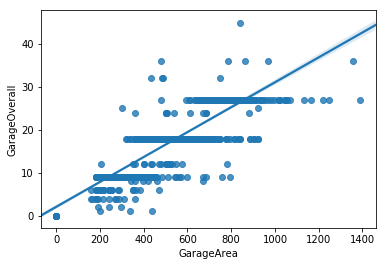

In [149]:
#drop one of these:
sns.regplot(ames.GarageArea, ames.GarageOverall)
print(ames[['GarageArea', 'GarageOverall']].corr())

#### Dummy variables for categorical variables

In [150]:
#dummy variables for categorical variables
centralac_dummies = pd.get_dummies(ames.CentralAir, drop_first=True, prefix='CentralAir')
centralac_dummies.head()

,CentralAir_Y
0,1
1,1
2,1
3,1
4,1


In [151]:
#add dummy variable
ames['CentralAir_Y'] = centralac_dummies
ames[['CentralAir_Y','CentralAir']].head()

,CentralAir_Y,CentralAir
0,1,Y
1,1,Y
2,1,Y
3,1,Y
4,1,Y


In [152]:
neighborhood_dummies = pd.get_dummies(ames.Neighborhood, drop_first=True)
#neighborhood_dummies.head()
neighborhood_list = neighborhood_dummies.columns

In [153]:
#add new dummy variables
ames[neighborhood_list] = neighborhood_dummies
ames[neighborhood_list].head()

,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,...,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [154]:
ames.Neighborhood.value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards     98
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     39
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

              CentralAir_Y  SalePrice
CentralAir_Y      1.000000   0.258056
SalePrice         0.258056   1.000000


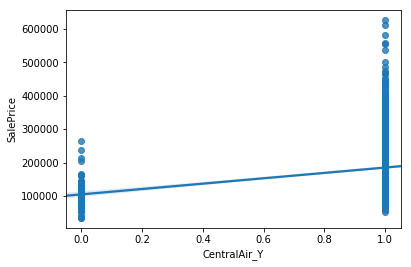

In [155]:
#check correlation with Central Air
sns.regplot(ames.CentralAir_Y, ames.SalePrice)
print(ames[['CentralAir_Y', 'SalePrice']].corr())

In [156]:
#Check neighborhood correlations
for index, n_name in enumerate(neighborhood_list):
    print(ames[[n_name, 'SalePrice']].corr())

            Blueste  SalePrice
Blueste    1.000000  -0.020632
SalePrice -0.020632   1.000000
             BrDale  SalePrice
BrDale     1.000000  -0.104017
SalePrice -0.104017   1.000000
            BrkSide  SalePrice
BrkSide    1.000000  -0.146958
SalePrice -0.146958   1.000000
           ClearCr  SalePrice
ClearCr     1.0000     0.0592
SalePrice   0.0592     1.0000
            CollgCr  SalePrice
CollgCr    1.000000   0.078745
SalePrice  0.078745   1.000000
            Crawfor  SalePrice
Crawfor    1.000000   0.075726
SalePrice  0.075726   1.000000
            Edwards  SalePrice
Edwards    1.000000  -0.185114
SalePrice -0.185114   1.000000
            Gilbert  SalePrice
Gilbert    1.000000   0.039686
SalePrice  0.039686   1.000000
             IDOTRR  SalePrice
IDOTRR     1.000000  -0.168547
SalePrice -0.168547   1.000000
            MeadowV  SalePrice
MeadowV    1.000000  -0.115644
SalePrice -0.115644   1.000000
            Mitchel  SalePrice
Mitchel    1.000000  -0.058127
SalePrice -

              TotRmsAbvGrd  GrLivArea
TotRmsAbvGrd      1.000000   0.833979
GrLivArea         0.833979   1.000000


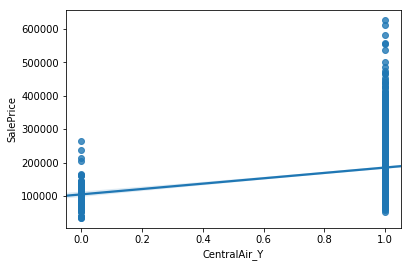

In [157]:
#drop TotRmsAbvGrd:
sns.regplot(ames.CentralAir_Y, ames.SalePrice)
print(ames[['TotRmsAbvGrd', 'GrLivArea']].corr())

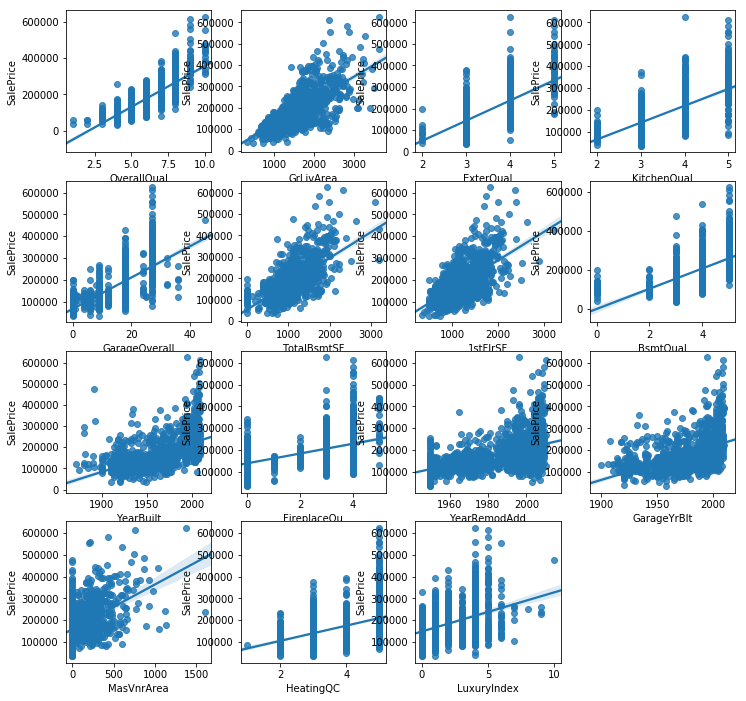

In [158]:
#check selected scatter plots against Sales Price, for promising features
listx = ['OverallQual',
'GrLivArea',
'ExterQual',
'KitchenQual',
'GarageOverall',
'TotalBsmtSF',
'1stFlrSF',
'BsmtQual',
'YearBuilt',
'FireplaceQu',
'YearRemodAdd',
'GarageYrBlt',
'MasVnrArea',
'HeatingQC',
'LuxuryIndex']
         
y=ames['SalePrice']

plt.figure(figsize = (12,12))
for index, col_name in enumerate(listx):
    #index starts at 0 and increments by 1
    plt.subplot(4, 4, index+1) #r x c plots
    sns.regplot(ames[col_name], y)    

               OverallQual  GrLivArea  ExterQual  KitchenQual  GarageOverall  \
OverallQual       1.000000   0.583519   0.721973     0.667869       0.606968   
GrLivArea         0.583519   1.000000   0.421998     0.407736       0.468044   
ExterQual         0.721973   0.421998   1.000000     0.712513       0.523398   
KitchenQual       0.667869   0.407736   0.712513     1.000000       0.510803   
GarageOverall     0.606968   0.468044   0.523398     0.510803       1.000000   
TotalBsmtSF       0.532666   0.394829   0.463420     0.427181       0.444768   
1stFlrSF          0.462042   0.522920   0.382493     0.374718       0.446435   
BsmtQual          0.625421   0.317494   0.561410     0.505876       0.450984   
YearBuilt         0.571712   0.192645   0.597409     0.528454       0.557862   
FireplaceQu       0.487899   0.477207   0.357152     0.349589       0.371973   
YearRemodAdd      0.550971   0.289264   0.587260     0.625260       0.430410   
GarageYrBlt       0.547320   0.227829   

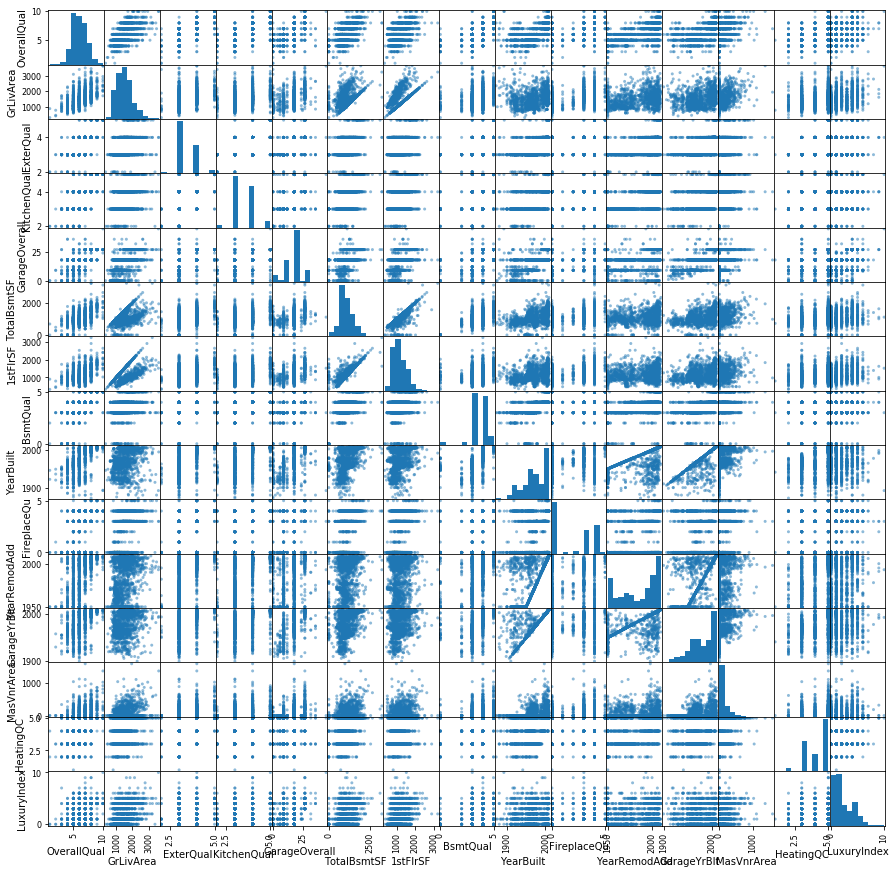

In [159]:
#check collinearity again
#many of these are correlated
scatter_matrix(ames[listx], figsize=[15,15]);
print(ames[listx].corr())

In [160]:
#Remove more features: following are the selected features to input into regression:
listx2 = ['OverallQual',
'GrLivArea',
'GarageOverall',
'TotalBsmtSF',
'YearBuilt',
'FireplaceQu',
'YearRemodAdd',
'MasVnrArea',
'HeatingQC',
'LuxuryIndex',
'NridgHt',
'OldTown']

**PROBLEM**

Using the `sklearn` implementation of `LinearRegression()`, create a test and train set from your housing data.  To begin, fit a linear model on the **Logarithm** of the sales column with the `GrLivArea` feature.  Use this as your baseline to compare your transformations to.  

Include the earlier transformations into a second linear model and try it out on the test set. Did the performance improve with your adjustments and transformations? 

Add polynomial features into the mix and see if you can get better improvement still.

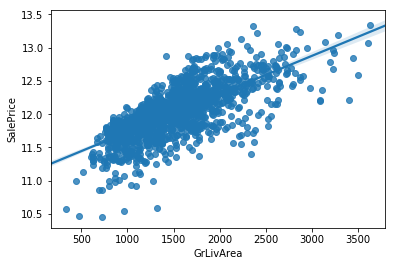

In [161]:
sns.regplot(ames.GrLivArea, np.log(ames.SalePrice))

In [162]:
#X = ames[listx2]
X = ames.GrLivArea
y = np.log(ames.SalePrice)

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [163]:
#Baseline regression:
lr = LinearRegression()
lr.fit(X_train.values.reshape(-1,1), y_train) 
y_pred = lr.predict(X_test.values.reshape(-1,1))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
score = lr.score(X_test.values.reshape(-1,1), y_test)
print('Score:', score, '\nRMSE:', rmse)

Score: 0.536297482769 
RMSE: 0.26449111816


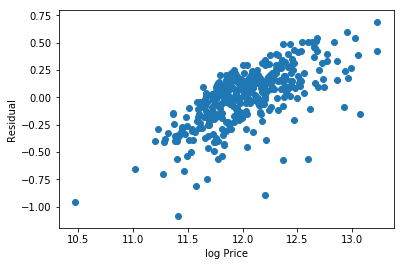

In [164]:
#residual plot: baseline regression
# *** looks bad, there is a pattern ***
residuals = y_test - y_pred
plt.scatter(y_test, residuals) #original data vs resid's
plt.xlabel('log Price')
plt.ylabel('Residual')

#plt.scatter(y_test, y_pred)
#plt.scatter(y_test, y_test, marker='x')

#### Add polynomial features

In [165]:
#create pipeline that adds polynomial features
#and then fits a LinearRegression model to this
#we omit the degree in the PolyFeatures, because we will grid search for the best degree
pipe = make_pipeline(PolynomialFeatures(), LinearRegression())

In [166]:
#do grid search to find best polynomial degree
params = {'polynomialfeatures__degree':[2,3,4,5]}
#--> the polynomial degrees we'll search over

In [167]:
#instantiate the grid search object
#use 5 folds in cross validation
grid = GridSearchCV(pipe, param_grid=params, cv=5)

In [168]:
#fit model
#looks like polynomial degree 3 is best
grid.fit(X_train.values.reshape(-1,1), y_train) 
grid.best_estimator_

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [169]:
#predictions with best poly degree
best = grid.best_estimator_
y_pred = best.predict(X_test.values.reshape(-1,1))

In [170]:
#no improvement in score with poly regression
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
score = best.score(X_test.values.reshape(-1,1), y_test)
print('Score:', score, '\nRMSE:', rmse)

Score: 0.548578721383 
RMSE: 0.26096506877


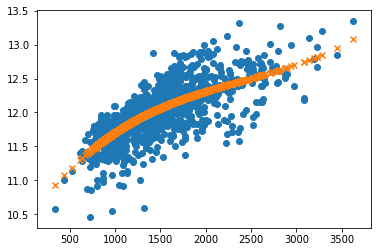

In [171]:
#see poly fit, on train data
plt.scatter(X_train, y_train)
plt.scatter(X_train, best.predict(X_train.values.reshape(-1,1)), marker='x')

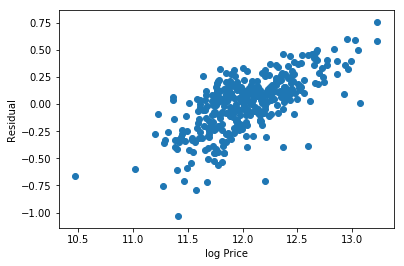

In [172]:
#residual plot: baseline polynomial regression
# *** still looks bad, there is a pattern ***
residuals = y_test - y_pred
plt.scatter(y_test, residuals) #original data vs resid's
plt.xlabel('log Price')
plt.ylabel('Residual')

#plt.scatter(y_test, y_pred)
#plt.scatter(y_test, y_test, marker='x')

#### Add more features

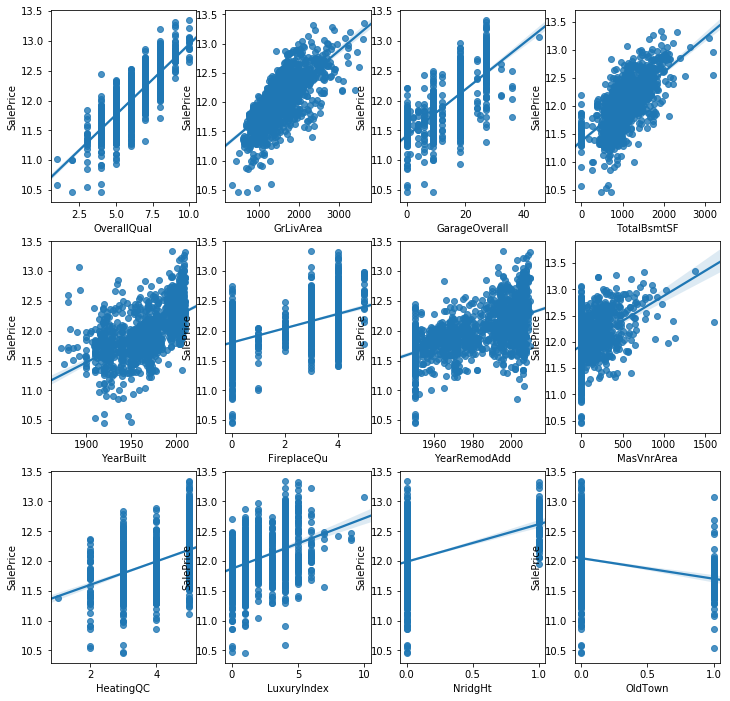

In [173]:
#check scatterplots of Sales Pricea against all the features
y = np.log(ames.SalePrice)

plt.figure(figsize = (12,12))
for index, col_name in enumerate(listx2):
    #index starts at 0 and increments by 1
    plt.subplot(3, 4, index+1) #r x c plots
    sns.regplot(ames[col_name], y)   

In [174]:
X = ames[listx2]
y = np.log(ames.SalePrice)

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [175]:
#linear regression with more features:
#RMSE looks much better
lr = LinearRegression()
lr.fit(X_train, y_train) 
y_pred = lr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
score = lr.score(X_test, y_test)
print('Score:', score, '\nRMSE:', rmse)

Score: 0.851484492299 
RMSE: 0.151756838525


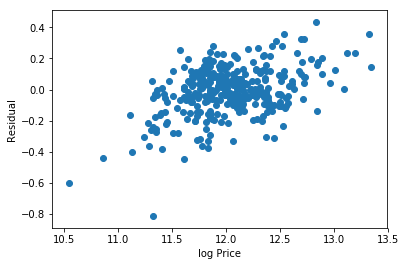

In [176]:
#residual plot: linear regression with more features
# *** looks better, but there is still some pattern ***
residuals = y_test - y_pred
plt.scatter(y_test, residuals) #original data vs resid's
plt.xlabel('log Price')
plt.ylabel('Residual')

#plt.scatter(y_test, y_pred)
#plt.scatter(y_test, y_test, marker='x')

#### Try Regularized Regression Methods

In [177]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

In [178]:
#we omit alpha in the Ridge, because we will grid search for the best alpha 
#we transform X data using StandardScaler, then fit using Ridge regression
pipe = make_pipeline(StandardScaler(), Ridge()) 

In [179]:
params = {'ridge__alpha': [0.1, 1.0, 4.0, 10, 100]}
#--> the Regularized alphas we'll search over

In [180]:
#instantiate the grid search object
#use 5 folds in cross validation
grid = GridSearchCV(pipe, param_grid=params, cv=5)

In [181]:
#NEED TO DO TRAIN/TEST SPLIT AGAIN??
#X = ames[listx2]
#y = np.log(ames.SalePrice)

#X_train, X_test, y_train, y_test = train_test_split(X, y)

In [182]:
#fit model
#looks like Ridge alpha 10 is best
grid.fit(X_train, y_train) 
grid.best_estimator_

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [183]:
#predictions with best alpha
best = grid.best_estimator_
y_pred = best.predict(X_test)

In [184]:
#no improvement in score with Ridge regression over linear regression
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
score = best.score(X_test, y_test)
print('Score:', score, '\nRMSE:', rmse)

Score: 0.851403419827 
RMSE: 0.151798253807


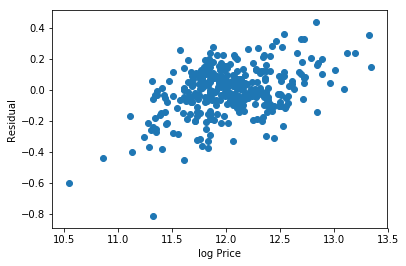

In [185]:
#residual plot: Ridge regression with more features
# *** there is still some pattern ***
residuals = y_test - y_pred
plt.scatter(y_test, residuals) #original data vs resid's
plt.xlabel('log Price')
plt.ylabel('Residual')

#plt.scatter(y_test, y_pred)
#plt.scatter(y_test, y_test, marker='x')

#### Try Lasso

In [186]:
from sklearn.linear_model import Lasso

#we omit alpha in the Lasso, because we will grid search for the best alpha 
#we transform X data using StandardScaler, then fit using Lassso regression
pipe = make_pipeline(StandardScaler(), Lasso()) 

In [187]:
params = {'lasso__alpha': [0.1, 1.0, 4.0, 10, 100]}
#--> the Regularized alphas we'll search over

In [188]:
#instantiate the grid search object
#use 5 folds in cross validation
grid = GridSearchCV(pipe, param_grid=params, cv=5)

In [189]:
#NEED TO DO TRAIN/TEST SPLIT AGAIN??
#X = ames[listx2]
#y = np.log(ames.SalePrice)

#X_train, X_test, y_train, y_test = train_test_split(X, y)

In [190]:
#fit model
#looks like Ridge alpha 0.1 is best
grid.fit(X_train, y_train) 
grid.best_estimator_

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [191]:
#predictions with best alpha
best = grid.best_estimator_
y_pred = best.predict(X_test)

In [192]:
#no improvement in score with Lasso regression over Ridge regression
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
score = best.score(X_test, y_test)
print('Score:', score, '\nRMSE:', rmse)

Score: 0.698895411232 
RMSE: 0.216083226243


#### Add more polynomial features

In [193]:
#create pipeline that adds polynomial features
#and then fits a LinearRegression model to this
#we omit the degree in the PolyFeatures, because we will grid search for the best degree
pipe = make_pipeline(PolynomialFeatures(), LinearRegression())

In [194]:
#do grid search to find best polynomial degree
params = {'polynomialfeatures__degree':[2,3,4]}
#--> the polynomial degrees we'll search over

In [195]:
#instantiate the grid search object
#use 5 folds in cross validation
grid = GridSearchCV(pipe, param_grid=params, cv=5)

In [196]:
#NEED TO DO TRAIN/TEST SPLIT AGAIN??
#X = ames[listx2]
#y = np.log(ames.SalePrice)

#X_train, X_test, y_train, y_test = train_test_split(X, y)

In [197]:
#fit model
#looks like polynomial degree=2 is best
grid.fit(X_train, y_train) 
grid.best_estimator_

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [198]:
#predictions with best polynomial degree
best = grid.best_estimator_
y_pred = best.predict(X_test)

In [199]:
#no improvement in score compared to the best of the prior methods
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
score = best.score(X_test, y_test)
print('Score:', score, '\nRMSE:', rmse)

Score: 0.854235020408 
RMSE: 0.15034499207


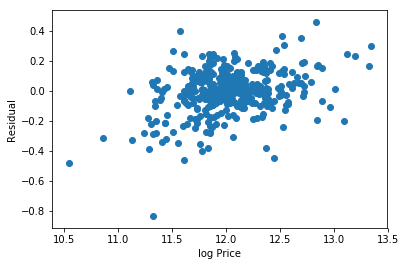

In [200]:
#residual plot: polynomial regression with more features
# *** there is still some pattern ***
residuals = y_test - y_pred
plt.scatter(y_test, residuals) #original data vs resid's
plt.xlabel('log Price')
plt.ylabel('Residual')

#plt.scatter(y_test, y_pred)
#plt.scatter(y_test, y_test, marker='x')